# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio, AssetEvaluator, metrics

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
file_k200 = 'kospi200_prices.csv'
file_etf = 'etfs_all.csv'
file_tdf = '금융자산운용 - export.csv'

download = False
close_today = False

## KOSPI200

In [4]:
k200 = DataManager(
    universe = 'KOSPI200',
    file = file_k200,
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-15 uploaded.
df_prices updated


In [5]:
kw = dict(
    n_years=3, 
    close_today=close_today,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if download else None

In [6]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [7]:
etf = DataManager(
    universe = 'ETF',
    file = file_etf,
    path = path_data
)
etf.upload()

870 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [8]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if download else None

In [9]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [10]:
tdf = DataManager(
    universe = 'TDF',
    file = file_tdf, upload_type = 'rate',
    path = path_data
)
tdf.upload()
tdf.get_date_range()

Estimating price from rate ...
  error: -0.07 %
  error: -0.00 %
  error: 0.16 %
  error: -0.13 %
  error: 0.00 %
5 assets from 2017-08-14 to 2024-07-15 uploaded.
df_prices updated


,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-07-14
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-07-15


In [11]:
df_tdf = tdf.df_prices
assetnames_tdf = tdf.get_names()
assetnames_tdf

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
3) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
4) K55206C96311: 키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)

# Backtest

## KOSPI 200

In [12]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [13]:
lags = dict(lookback=12, lag=5)

In [14]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [15]:
select = 'Momentum'
kwargs_build = dict(
    name=f'KOSPI:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [16]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'KOSPI:{select}', select =select,
))
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, KOSPI:Momentum


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s]

Returning stats


,KOSPI:Momentum,KODEX200
start,2021-01-03,2021-01-03
end,2024-07-15,2024-07-15
total_return,6.076125,0.073467
cagr,0.740994,0.020291
calmar,2.81907,0.072933
max_drawdown,-0.262851,-0.278222
avg_drawdown,-0.059227,-0.053124
avg_drawdown_days,17.604651,150.666667
daily_vol,0.39115,0.145841
daily_sharpe,1.642354,0.213445


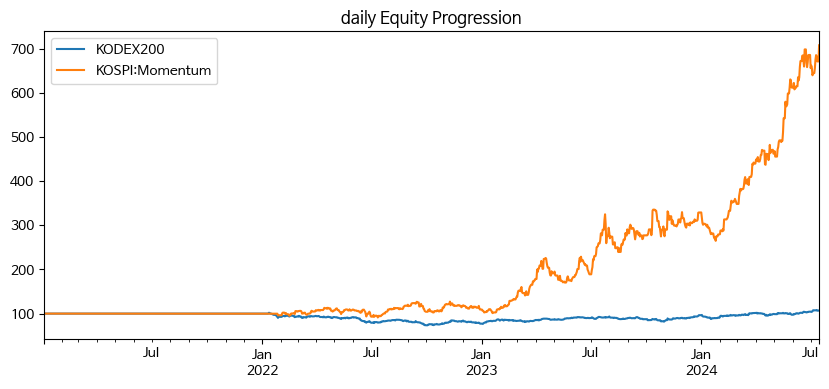

In [16]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [17]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','KOSPI:Momentum']]

## ETF

In [18]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year


In [19]:
lags = dict(lookback=12, lag=5)

In [20]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [21]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='ETF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='ETF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='ETF:InvVol', weigh='InvVol', **kwargs_build)

Backtesting 4 strategies: KODEX200, ETF:Eqaully, ETF:ERC, ETF:InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


Returning stats


,ETF:Eqaully,ETF:ERC,ETF:InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,0.261244,0.214048,0.190885,0.341347
cagr,0.094482,0.078365,0.070315,0.121013
calmar,2.570011,2.036211,1.863784,0.960111
max_drawdown,-0.036763,-0.038486,-0.037727,-0.126041
avg_drawdown,-0.007851,-0.007471,-0.00685,-0.025636
avg_drawdown_days,12.771429,17.346154,17.461538,19.68
daily_vol,0.046101,0.040422,0.038887,0.125812
daily_sharpe,2.030856,1.93376,1.810946,0.993648


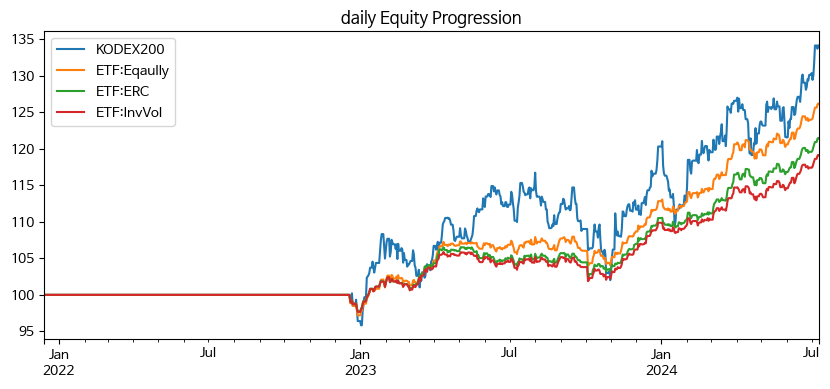

In [22]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [23]:
df = bm.get_historical()
df_pf = df_pf.join(df[['ETF:Eqaully', 'ETF:ERC']])

## TDF

In [24]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 365,
    asset_names = assetnames_tdf
)
bm = BacktestManager(df_tdf, **kwargs_bm)

period reset: 2018-07-26 ~ 2024-06-16
running self.util_check_days_in_year to check days in a year


In [25]:
lags = dict(lookback=12, lag=5)

In [26]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [27]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='TDF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='TDF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='TDF:InvVol', weigh='InvVol', **kwargs_build)

In [28]:
choice = ['K55301BU6139', 'K55206C95800']

kwargs_build.update(dict(
    name='TDF2:Eqaully', select ='all', 
    weigh='Specified',  weights=choice
))
bm.build(**kwargs_build)

Backtesting 5 strategies: KODEX200, TDF:Eqaully, TDF:ERC, TDF:InvVol, TDF2:Eqaully


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]

Returning stats


,TDF2:Eqaully,TDF:Eqaully,TDF:InvVol,TDF:ERC,KODEX200
start,2018-07-25,2018-07-25,2018-07-25,2018-07-25,2018-07-25
end,2024-06-14,2024-06-14,2024-06-14,2024-06-14,2024-06-14
total_return,0.386717,0.369804,0.334643,0.338897,0.548027
cagr,0.057086,0.054885,0.050238,0.050805,0.077024
calmar,0.264737,0.264097,0.262103,0.262441,0.222392
max_drawdown,-0.215632,-0.207823,-0.191671,-0.193587,-0.346343
avg_drawdown,-0.01504,-0.014127,-0.012421,-0.012834,-0.041874
avg_drawdown_days,32.085106,31.333333,29.86,30.653061,53.935484
daily_vol,0.066812,0.064454,0.058252,0.058886,0.183777
daily_sharpe,0.884602,0.881452,0.891091,0.891528,0.505265


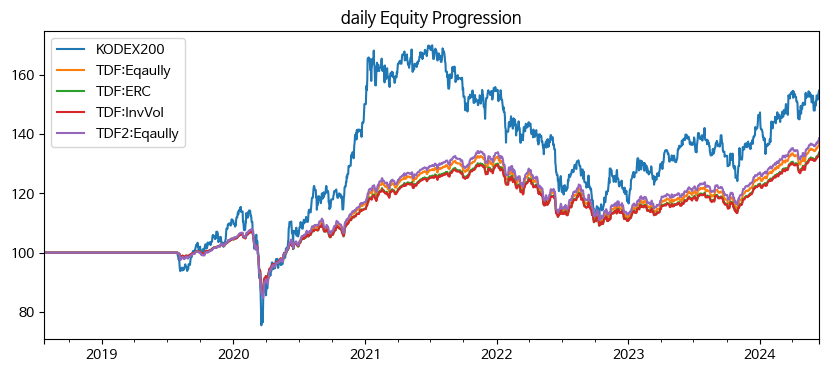

In [29]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [30]:
df = bm.get_historical()
df_pf = df_pf.join(df['TDF2:Eqaully'])

## Summary

In [31]:
ae = AssetEvaluator(df_pf, 245)

ETF:Eqaully: 151
ETF:ERC: 151
TDF2:Eqaully: 237


In [32]:
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

,ETF:Eqaully,ETF:ERC,KOSPI:Momentum,TDF2:Eqaully,KODEX200
start,2022-12-19,2022-12-19,2022-01-25,2022-01-10,2022-01-10
end,2024-07-10,2024-07-10,2024-07-15,2024-06-14,2024-07-15
total_return,0.261244,0.214048,6.076125,0.048404,0.073467
cagr,0.160659,0.132589,1.208567,0.019678,0.02864
calmar,4.37009,3.44514,4.597925,0.120567,0.10294
max_drawdown,-0.036763,-0.038486,-0.262851,-0.16321,-0.278222
avg_drawdown,-0.007851,-0.007471,-0.059227,-0.02669,-0.053124
avg_drawdown_days,12.771429,17.346154,17.604651,106.375,150.666667
daily_vol,0.059009,0.051766,0.467956,0.068992,0.173314
daily_sharpe,2.624961,2.498196,1.973106,0.324167,0.253552


# Transaction

## KOSPI200

In [33]:
kwargs = dict(
    name='KOSPI Momentum',
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-05-14 loaded.


In [34]:
kwargs = dict(
    #date = '2024-05-15',
    date = None,
    n_assets = 5,
    capital = 0,
    #save = False
    save = True
)
df = pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-07-10 to 2024-07-10
Weights of assets determined by ERC.
Mean absolute error of weights: 4 %
Value 26,299,650, Profit 9,661,750
All transactions saved to pf_k200_momentum_240715.csv


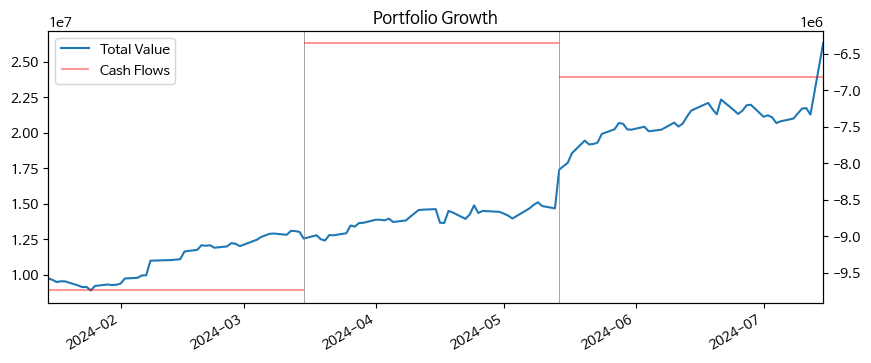

In [35]:
pf_k200.plot()

In [36]:
pf_k200.performance(metrics=metrics)

,KOSPI Momentum
start,2024-01-15
end,2024-07-15
total_return,1.700086
cagr,6.340371
calmar,72.46787
max_drawdown,-0.087492
avg_drawdown,-0.031211
avg_drawdown_days,6.823529
daily_vol,0.551563
daily_sharpe,3.987456


In [37]:
#pf_k200.performance(metrics=metrics2)
df_pf = pf_k200.get_historical()

## ETF

In [38]:
kwargs = dict(
    name='ETF6',
    file='pf_etf_static.csv',
    method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=245,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [39]:
pf_etf.plot()

ERROR: No transaction record


In [40]:
pf_etf.performance(metrics=metrics)

ERROR: No transaction record


In [41]:
pf_etf.transaction_pipeline(save=False)

6 assets from 2023-07-05 to 2024-07-05 prepared for weight analysis
Weights of assets determined by ERC.
Mean absolute error of weights: 1 %
Value 9,894,915, Profit 0
Set save=True to save transaction record


name   price  transaction  net weight  \
date       asset                                                           
2024-07-10 069500             KODEX 200   39735           21   21  0.085   
           273130  KODEX 종합채권(AA-이상)액티브  112380           24   24  0.275   
           148070          KOSEF 국고채10년  114330           16   16  0.184   
           379800      KODEX 미국S&P500TR   17560           88   88  0.156   
           411060            ACE KRX금현물   15005           94   94  0.142   
           284430        KODEX 200미국채혼합   13490          117  117  0.159   

                  weight*  
date       asset           
2024-07-10 069500   0.084  
           273130   0.273  
           148070   0.185  
           379800   0.156  
           411060   0.143  
           284430   0.160

In [42]:
df_pf = df_pf.to_frame().join(pf_etf.get_historical(), how='outer')

## TDF

In [43]:
choice = ['K55301BU6139', 'K55206C95800']

In [44]:
kwargs = dict(
    name='TDF2',
    file='pf_tdf_static.csv',
    lookback=12, lag=5,
    path=path_tran,
    days_in_year=365,
    asset_names=assetnames_tdf,
)

pf_tdf = StaticPortfolio(df_tdf[choice], **kwargs)

period reset: 2018-07-26 ~ 2024-07-14
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-06-19 loaded.


In [45]:
kwargs = dict(
    method_weigh = 'Equally', 
    date = '2024-06-19',
    save = True
)
df = pf_tdf.transaction_pipeline(**kwargs)

2 assets from 2023-06-14 to 2024-06-14 prepared for weight analysis
ERROR: check the date as no new transaction
The profit from the most recent transaction: 0


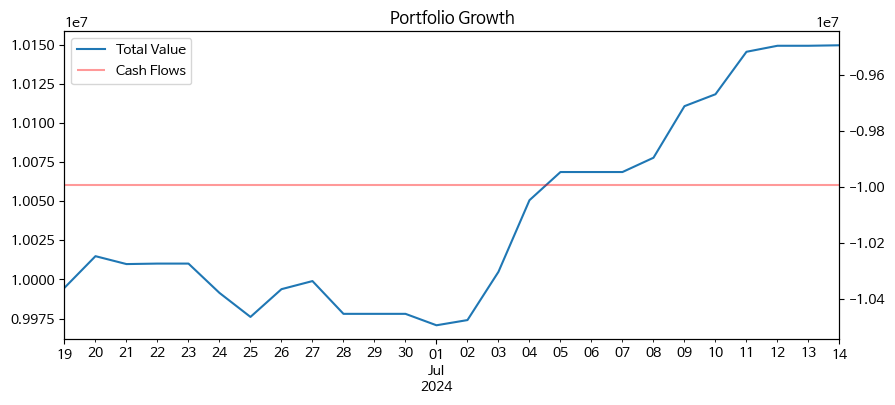

In [46]:
pf_tdf.plot()

In [47]:
pf_tdf.performance(metrics=metrics)

,TDF2
start,2024-06-19
end,2024-07-14
total_return,0.01553
cagr,0.252514
calmar,57.175393
max_drawdown,-0.004416
avg_drawdown,-0.004416
avg_drawdown_days,13.0
daily_vol,0.025607
daily_sharpe,6.080427


In [48]:
df_pf = df_pf.join(pf_tdf.get_historical(), how='outer')
df_pf.tail()

,KOSPI Momentum,ETF6,TDF2
2024-07-11,21730600.0,NaN,1.014572e+07
2024-07-12,21270700.0,NaN,1.014957e+07
2024-07-13,NaN,NaN,1.014957e+07
2024-07-14,NaN,NaN,1.014988e+07
2024-07-15,26299650.0,NaN,NaN


## Summary

In [49]:
ae = AssetEvaluator(df_pf, 242)
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

KOSPI Momentum: 238
ETF6: 0
TDF2: 0


,KOSPI Momentum,ETF6,TDF2
start,2024-01-15,2024-07-10,2024-06-19
end,2024-07-15,2024-07-10,2024-07-14
total_return,1.700086,NaN,0.01553
cagr,6.340371,NaN,0.252514
calmar,72.46787,NaN,57.175393
max_drawdown,-0.087492,NaN,-0.004416
avg_drawdown,-0.031211,NaN,-0.004416
avg_drawdown_days,6.823529,NaN,13.0
daily_vol,0.551563,NaN,0.025607
daily_sharpe,3.987456,NaN,6.080427


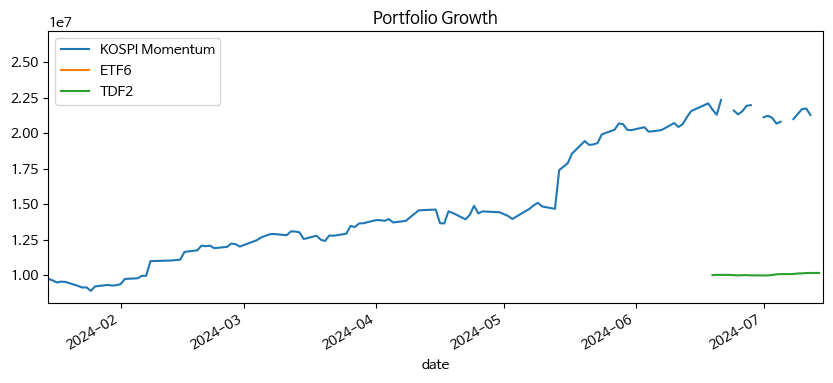

In [50]:
_ = ae.plot_historical()